## Load Data

In [340]:
# import libraries
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import norm
from scipy.stats import uniform
from scipy.stats import boxcox
import math
import geopandas as gpd
from shapely.geometry import Point, Polygon

# model stuff
from sklearn import linear_model
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor
from xgboost import plot_importance

In [341]:
# import housing data
raw_train = pd.read_csv('../Data/EdmontonRealEstateData_train.csv')
raw_test = pd.read_csv('../Data/EdmontonRealEstateData_test.csv')

## Exploratory Data Analysis

In [342]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42779 entries, 0 to 42778
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  42779 non-null  int64  
 1   taxroll_number              42779 non-null  int64  
 2   landuse_description         42779 non-null  object 
 3   market_building_class       40471 non-null  object 
 4   effective_build_year        40455 non-null  float64
 5   net_area                    42779 non-null  float64
 6   basement_finished           42779 non-null  object 
 7   has_garage                  42779 non-null  object 
 8   has_fireplace               42779 non-null  object 
 9   assessed_value              42779 non-null  int64  
 10  house_suit                  0 non-null      float64
 11  house_number                42779 non-null  int64  
 12  house_suff                  18 non-null     object 
 13  street_name                 427

In [343]:
raw_train.isna().sum().sort_values(ascending=False)

house_suit                    42779
house_suff                    42761
postal_code                    2492
effective_build_year           2324
site_coverage                  2323
market_building_class          2308
build_year_mbc                 2308
fully_complete                 2304
Unnamed: 0                        0
building_count                    0
walkout_basement                  0
air_conditioning                  0
display_type                      0
valuation_group                   0
tot_gross_area_description        0
geometry                          0
result_code                       0
lon                               0
lot_size                          0
full_address                      0
fully_taxable                     0
neighbourhood                     0
taxroll_number                    0
city                              0
street_name                       0
house_number                      0
assessed_value                    0
has_fireplace               

<AxesSubplot:>

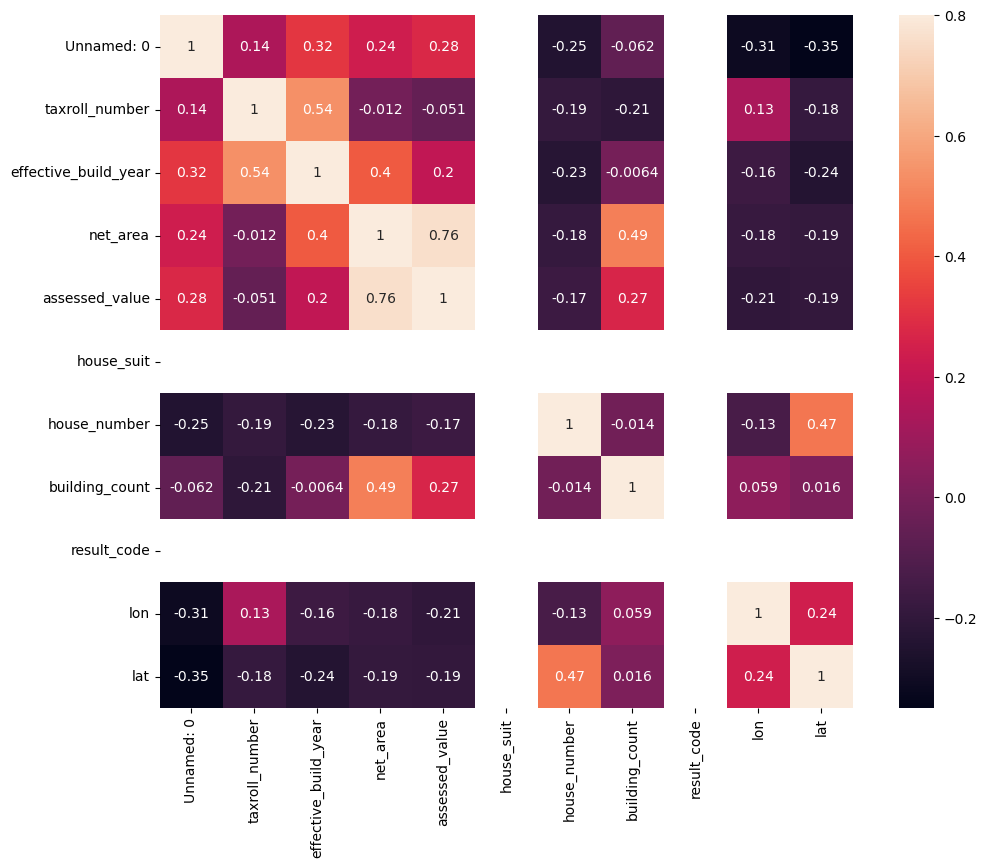

In [344]:
# correlation matrix
corrmat = raw_train.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat,annot=True, vmax=0.8, square=True)

In [345]:
raw_train['assessed_value'].describe()

count    4.277900e+04
mean     4.770349e+05
std      2.583694e+05
min      4.150000e+04
25%      3.485000e+05
50%      4.225000e+05
75%      5.365000e+05
max      8.447500e+06
Name: assessed_value, dtype: float64

<AxesSubplot:xlabel='net_area', ylabel='assessed_value'>

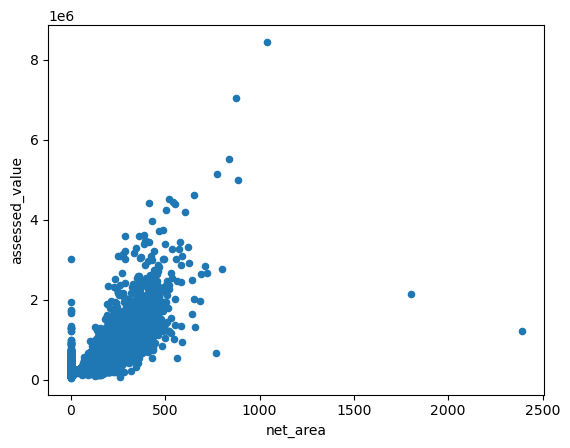

In [346]:
data = pd.concat([raw_train['assessed_value'], raw_train['net_area']], axis=1)
data.plot.scatter(x='net_area', y='assessed_value')

In [347]:
df = raw_train
df = df[(df['assessed_value'] >= np.percentile(df['assessed_value'], 0.5)) &
       (df['assessed_value'] <= np.percentile(df['assessed_value'], 99.5)) &
       (df['lat'] >= np.percentile(df['lat'], 0.05)) &
       (df['lat'] < np.percentile(df['lat'], 99.95)) &
       (df['lon'] >= np.percentile(df['lon'], 0.05)) &
       (df['lon'] <= np.percentile(df['lon'], 99.95))]

In [348]:
street_map = gpd.read_file('../Data/Neighbourhood_Boundaries/geo_export_89c8073e-fe24-4f48-981c-18aca8dbcc87.shp')
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
geo_df = gpd.GeoDataFrame(df,geometry=geometry)

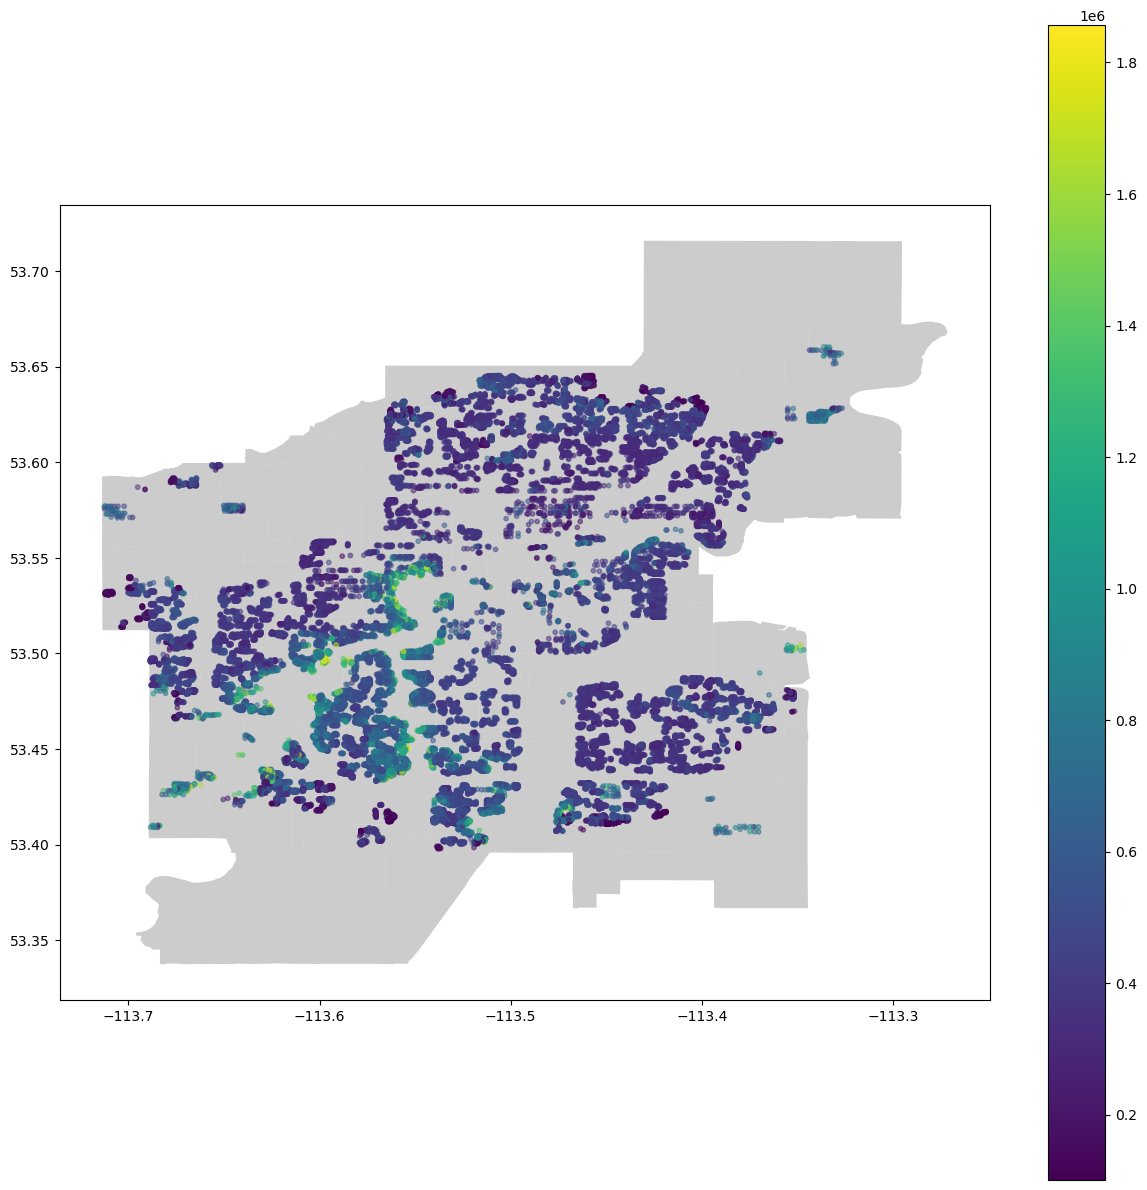

In [349]:
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha=0.4, color='grey')
geo_df.plot(column='assessed_value', ax=ax, alpha=0.5, legend=True, markersize=10)
plt.show()

## Data Cleaning & Preprocessing

In [350]:
# drop columns with uninteresting parameters
train = raw_train.drop(['house_suit','house_number','house_suff','street_name', 'city', 'full_address', 'fully_taxable',\
                      'display_type', 'geometry', 'result_code','landuse_description', 'postal_code', 'effective_build_year', 'market_building_class'], axis=1)

test = raw_test.drop(['house_suit','house_number','house_suff','street_name', 'city', 'full_address', 'fully_taxable',\
                      'display_type', 'geometry', 'result_code','landuse_description','postal_code', 'effective_build_year', 'market_building_class'], axis=1)

# get rid of unnamed column
train = train.iloc[:,1:]

test = test.iloc[:,1:]

In [351]:
train.isna().sum().sort_values(ascending=False)

site_coverage                 2323
build_year_mbc                2308
fully_complete                2304
taxroll_number                   0
lon                              0
tot_gross_area_description       0
valuation_group                  0
air_conditioning                 0
walkout_basement                 0
building_count                   0
net_area                         0
lot_size                         0
neighbourhood                    0
assessed_value                   0
has_fireplace                    0
has_garage                       0
basement_finished                0
lat                              0
dtype: int64

In [352]:
test.isna().sum().sort_values(ascending=False)

site_coverage                 629
build_year_mbc                625
fully_complete                624
taxroll_number                  0
lon                             0
tot_gross_area_description      0
valuation_group                 0
air_conditioning                0
walkout_basement                0
building_count                  0
net_area                        0
lot_size                        0
neighbourhood                   0
assessed_value                  0
has_fireplace                   0
has_garage                      0
basement_finished               0
lat                             0
dtype: int64

In [353]:
# turn build year into age
train['build_year_mbc'] = train['build_year_mbc'].str.split(',', n=1).str[0]
train['build_year_mbc'] = pd.to_numeric(train['build_year_mbc'])
train['build_year_mbc'] = 2022 - train['build_year_mbc']
mean_age = train['build_year_mbc'].mean()
train['build_year_mbc'] = train['build_year_mbc'].fillna(mean_age)

test['build_year_mbc'] = test['build_year_mbc'].str.split(',', n=1).str[0]
test['build_year_mbc'] = pd.to_numeric(test['build_year_mbc'])
test['build_year_mbc'] = 2022 - test['build_year_mbc']
mean_age = test['build_year_mbc'].mean()
test['build_year_mbc'] = test['build_year_mbc'].fillna(mean_age)

In [354]:
# fully_complete data is blank for undeveloped residential land, impute blank values as None
train['fully_complete'] = train['fully_complete'].fillna("NO")
test['fully_complete'] = test['fully_complete'].fillna("NO")

# incomplete site_coverage data is mainly undeveloped residential land, impute blank values with 0
train['site_coverage'] = train['site_coverage'].fillna("0%")
test['site_coverage'] = test['site_coverage'].fillna("0%")

train['site_coverage'] = train['site_coverage'].str.rstrip('%').astype('float') / 100.0
test['site_coverage'] = test['site_coverage'].str.rstrip('%').astype('float') / 100.0

# incomplete market_building_class is mainly undeveloped residential land, imput blank values with 'NO MARKET BUILDING CLASS'
#train['market_building_class'] = train['market_building_class'].fillna("NO MARKET BUILDING CLASS")
#test['market_building_class'] = test['market_building_class'].fillna("NO MARKET BUILDING CLASS")

In [355]:
test.isna().sum().sort_values(ascending=False)

taxroll_number                0
net_area                      0
lon                           0
tot_gross_area_description    0
site_coverage                 0
valuation_group               0
air_conditioning              0
walkout_basement              0
build_year_mbc                0
building_count                0
lot_size                      0
fully_complete                0
neighbourhood                 0
assessed_value                0
has_fireplace                 0
has_garage                    0
basement_finished             0
lat                           0
dtype: int64

In [356]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10695 entries, 0 to 10694
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   taxroll_number              10695 non-null  int64  
 1   net_area                    10695 non-null  float64
 2   basement_finished           10695 non-null  object 
 3   has_garage                  10695 non-null  object 
 4   has_fireplace               10695 non-null  object 
 5   assessed_value              10695 non-null  int64  
 6   neighbourhood               10695 non-null  object 
 7   fully_complete              10695 non-null  object 
 8   lot_size                    10695 non-null  object 
 9   building_count              10695 non-null  int64  
 10  build_year_mbc              10695 non-null  float64
 11  walkout_basement            10695 non-null  object 
 12  air_conditioning            10695 non-null  object 
 13  valuation_group             106

In [357]:
# just keep m^2 value for tot_gross_area_description
train['tot_gross_area_description'] = train['tot_gross_area_description'].astype(str)
train['tot_gross_area_description'] = train['tot_gross_area_description'].str.split(' ',1,expand=True)[0]
train['tot_gross_area_description'] = train['tot_gross_area_description'].astype('float')

# just keep m^2 value for tot_gross_area_description
test['tot_gross_area_description'] = test['tot_gross_area_description'].astype(str)
test['tot_gross_area_description'] = test['tot_gross_area_description'].str.split(' ',1,expand=True)[0]
test['tot_gross_area_description'] = test['tot_gross_area_description'].astype('float')

In [358]:
# just keep m^2 value lot_size
train['lot_size'] = train['lot_size'].astype(str)
train['lot_size'] = train['lot_size'].str.split(' ',1,expand=True)[0]
train['lot_size'] = train['lot_size'].astype('float')

test['lot_size'] = test['lot_size'].astype(str)
test['lot_size'] = test['lot_size'].str.split(' ',1,expand=True)[0]
test['lot_size'] = test['lot_size'].astype('float')

In [359]:
# encode some categorical variables
train['basement_finished'] = train['basement_finished'].map({'Yes': 1, 'NO': 0})
train['has_garage'] = train['has_garage'].map({'Yes': 1, 'NO': 0})
train['has_fireplace'] = train['has_fireplace'].map({'Yes': 1, 'NO': 0})
train['walkout_basement'] = train['walkout_basement'].map({'Yes': 1, 'NO': 0})
train['air_conditioning'] = train['air_conditioning'].map({'Yes': 1, 'NO': 0})
train['fully_complete'] = train['fully_complete'].map({'Yes': 1, 'NO': 0})

test['basement_finished'] = test['basement_finished'].map({'Yes': 1, 'NO': 0})
test['has_garage'] = test['has_garage'].map({'Yes': 1, 'NO': 0})
test['has_fireplace'] = test['has_fireplace'].map({'Yes': 1, 'NO': 0})
test['walkout_basement'] = test['walkout_basement'].map({'Yes': 1, 'NO': 0})
test['air_conditioning'] = test['air_conditioning'].map({'Yes': 1, 'NO': 0})
test['fully_complete'] = test['fully_complete'].map({'Yes': 1, 'NO': 0})

In [360]:
# categorize valuation group
train['valuation_group'] = train['valuation_group'].map({
    'RESIDENTIAL SOUTH': 0,
    'RESIDENTIAL NORTH': 1,
    'RESIDENTIAL WC': 2,
    'RESIDENTIAL RIVVAL': 3,
    'RESIDENTIAL LAND': 4,
    'SPECIAL PURPOSE': 5,
    'LAND': 6
})

test['valuation_group'] = test['valuation_group'].map({
    'RESIDENTIAL SOUTH': 0,
    'RESIDENTIAL NORTH': 1,
    'RESIDENTIAL WC': 2,
    'RESIDENTIAL RIVVAL': 3,
    'RESIDENTIAL LAND': 4,
    'SPECIAL PURPOSE': 5,
    'LAND': 6
})

labelencoder = LabelEncoder()
train['neighbourhood'] = labelencoder.fit_transform(train['neighbourhood'])
test['neighbourhood'] = labelencoder.fit_transform(test['neighbourhood'])

In [361]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10695 entries, 0 to 10694
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   taxroll_number              10695 non-null  int64  
 1   net_area                    10695 non-null  float64
 2   basement_finished           10695 non-null  int64  
 3   has_garage                  10695 non-null  int64  
 4   has_fireplace               10695 non-null  int64  
 5   assessed_value              10695 non-null  int64  
 6   neighbourhood               10695 non-null  int32  
 7   fully_complete              10695 non-null  int64  
 8   lot_size                    10695 non-null  float64
 9   building_count              10695 non-null  int64  
 10  build_year_mbc              10695 non-null  float64
 11  walkout_basement            10695 non-null  int64  
 12  air_conditioning            10695 non-null  int64  
 13  valuation_group             106

## Exploratory Data Analysis Part 2

<AxesSubplot:>

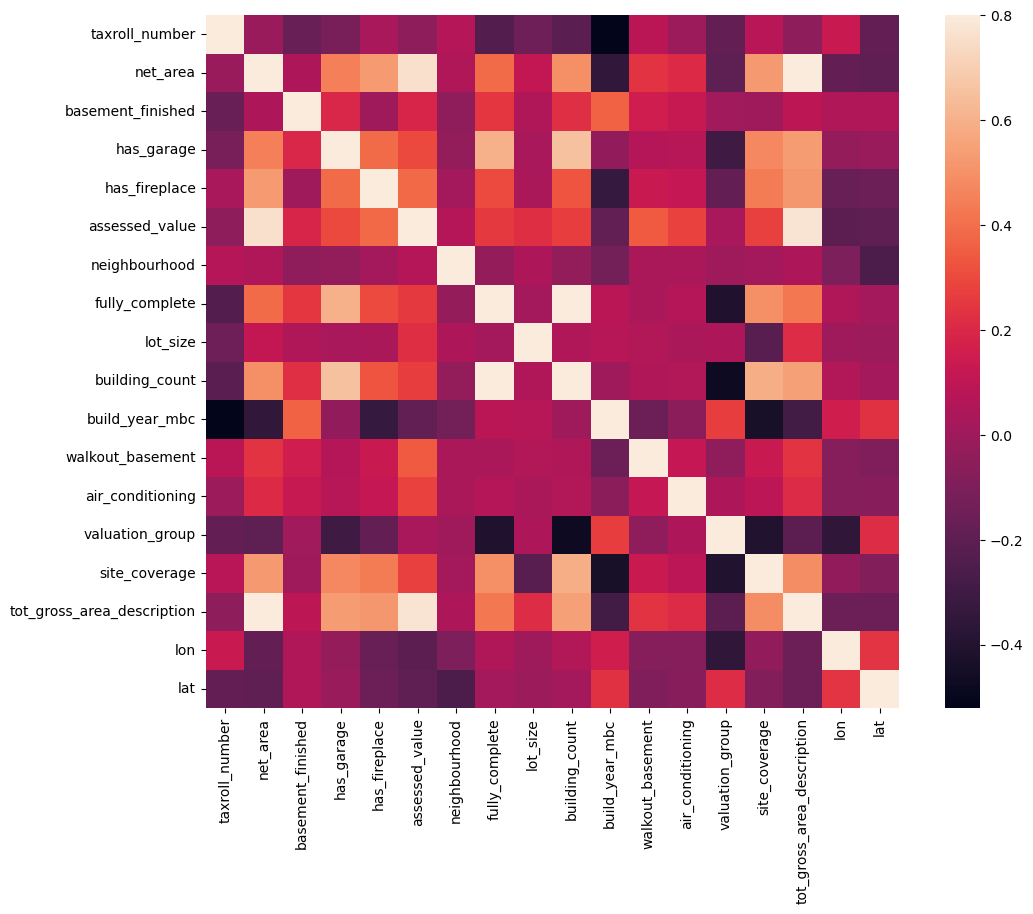

In [362]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=.8, square=True)

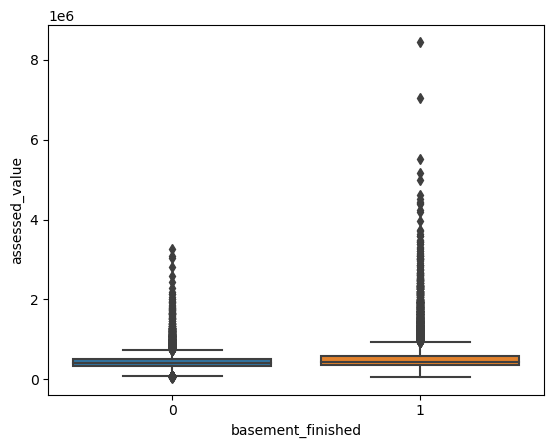

In [363]:
data = pd.concat([train['assessed_value'], train['basement_finished']], axis=1)
f,ax = plt.subplots()
fig = sns.boxplot(x='basement_finished', y='assessed_value', data=data)

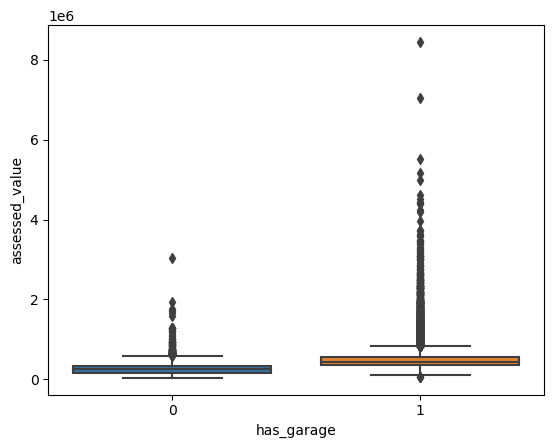

In [364]:
data = pd.concat([train['assessed_value'], train['has_garage']], axis=1)
f,ax = plt.subplots()
fig = sns.boxplot(x='has_garage', y='assessed_value', data=data)

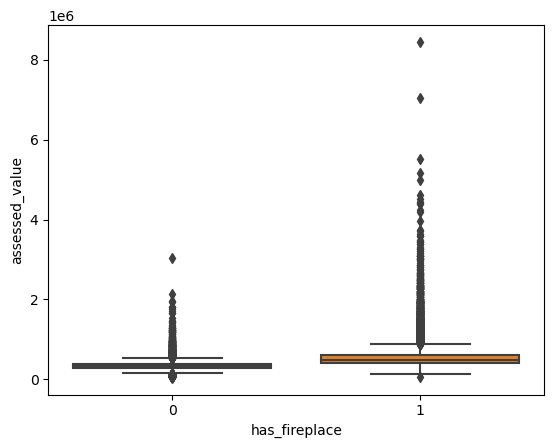

In [365]:
data = pd.concat([train['assessed_value'], train['has_fireplace']], axis=1)
f,ax = plt.subplots()
fig = sns.boxplot(x='has_fireplace', y='assessed_value', data=data)

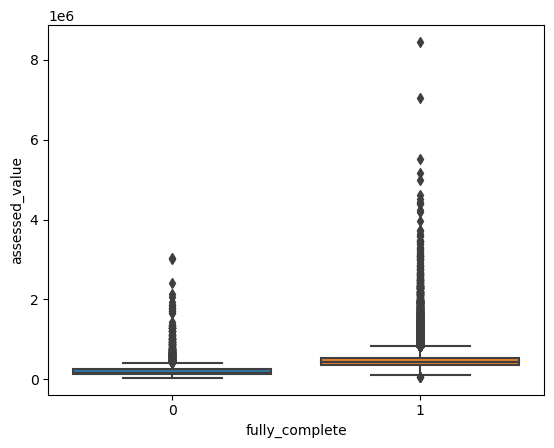

In [366]:
data = pd.concat([train['assessed_value'], train['fully_complete']], axis=1)
f,ax = plt.subplots()
fig = sns.boxplot(x='fully_complete', y='assessed_value', data=data)

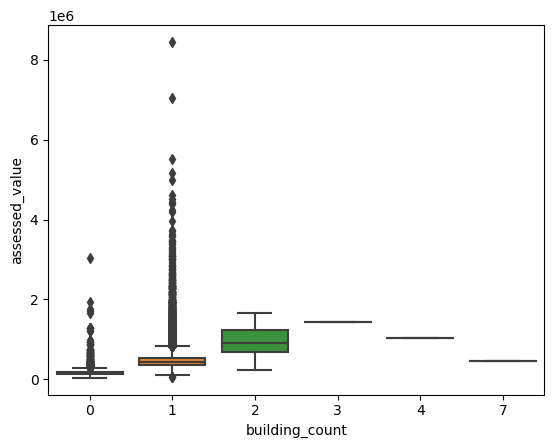

In [367]:
data = pd.concat([train['assessed_value'], train['building_count']], axis=1)
f,ax = plt.subplots()
fig = sns.boxplot(x='building_count', y='assessed_value', data=data)

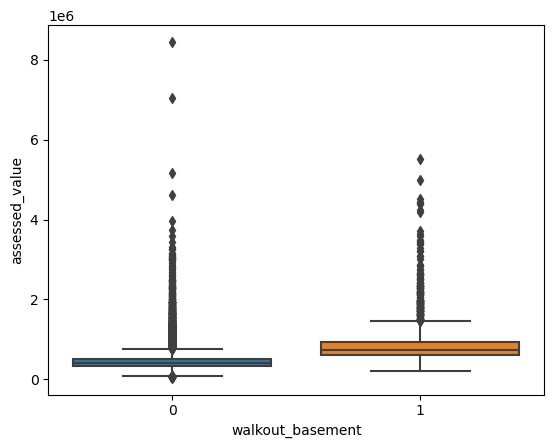

In [368]:
data = pd.concat([train['assessed_value'], train['walkout_basement']], axis=1)
f,ax = plt.subplots()
fig = sns.boxplot(x='walkout_basement', y='assessed_value', data=data)

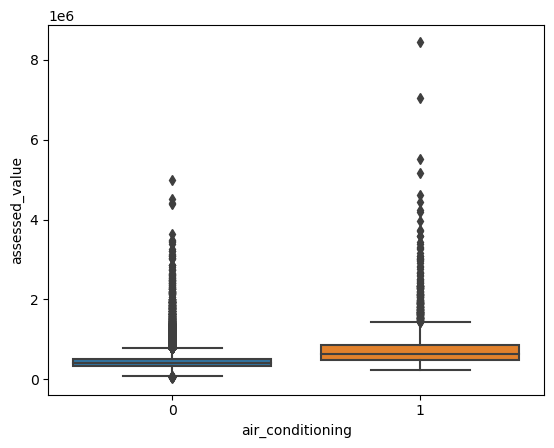

In [369]:
data = pd.concat([train['assessed_value'], train['air_conditioning']], axis=1)
f,ax = plt.subplots()
fig = sns.boxplot(x='air_conditioning', y='assessed_value', data=data)

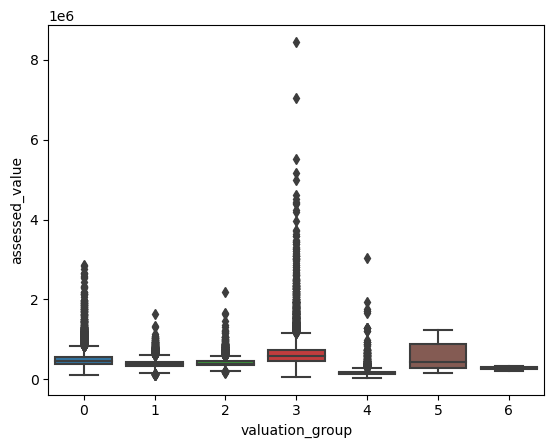

In [370]:
data = pd.concat([train['assessed_value'], train['valuation_group']], axis=1)
f,ax = plt.subplots()
fig = sns.boxplot(x='valuation_group', y='assessed_value', data=data)

## Model

In [371]:
X_train = train.loc[:,['net_area', 'basement_finished', 'has_garage', 'has_fireplace', 'lot_size', 'building_count','build_year_mbc', 'walkout_basement', 'air_conditioning', 'valuation_group', 'tot_gross_area_description', 'fully_complete','lon', 'lat']]
Y_train = train['assessed_value']

X_test = test.loc[:,['net_area', 'basement_finished', 'has_garage', 'has_fireplace', 'lot_size', 'building_count','build_year_mbc', 'walkout_basement', 'air_conditioning', 'valuation_group', 'tot_gross_area_description', 'fully_complete','lon', 'lat']]
Y_test = test['assessed_value']

result = pd.DataFrame(columns=('Simple Linear Regression','Multi-Linear Regression','Ridge','LASSO','RFR','XGBoost'), index = ['MAPE', 'RSME', 'r2'])

### Simple Linear Regression

In [372]:
X_train_2 = train.loc[:,['net_area']]
Y_train_2 = train['assessed_value']

X_test_2 = test.loc[:,['net_area']]
Y_test_2 = test['assessed_value']

slr_fit = LinearRegression().fit(X_train_2, Y_train_2)
slr_pred = slr_fit.predict(X_test_2)
slr_err = mean_squared_error(Y_test_2, slr_pred)
slr_r2 = r2_score(Y_test_2, slr_pred)
slr_mape = mean_absolute_percentage_error(Y_test_2, slr_pred)

result['Simple Linear Regression'] = [slr_mape, math.sqrt(slr_err), slr_r2]

### Multi-Linear Regression

In [373]:
lin_fit = LinearRegression().fit(X_train, Y_train)
lin_pred = lin_fit.predict(X_test)
lin_err = mean_squared_error(Y_test, lin_pred)
lin_r2 = r2_score(Y_test, lin_pred)
lin_mape = mean_absolute_percentage_error(Y_test, lin_pred)

result['Multi-Linear Regression'] = [lin_mape, math.sqrt(lin_err), lin_r2]
for i in range(len(lin_fit.coef_)):
    print(X_train.columns[i],lin_fit.coef_[i])

net_area 977.926057830012
basement_finished 60330.78710808773
has_garage -45854.12834549812
has_fireplace -3995.059058549441
lot_size 13.491853018189431
building_count -300330.11985537753
build_year_mbc -132.46482551676172
walkout_basement 158020.83887765423
air_conditioning 86491.09536122321
valuation_group 32429.3349604163
tot_gross_area_description 1604.9417154249495
fully_complete 208281.41464302313
lon 58447.977130231775
lat -294975.27616102144


### Ridge Regression

In [374]:
# hyperparameter tuning
# param_grid = {'alpha': np.logspace(-8,8,100)}
# ridge_mod = linear_model.Ridge()
# grid_search = GridSearchCV(lasso_mod, param_grid, cv=10)
# grid_search.fit(X_train, Y_train)
# grid_search.best_estimator_.alpha

In [375]:
ridge = linear_model.Ridge(alpha=220.513073990305)
ridge_fit = ridge.fit(X_train, Y_train)
ridge_pred = ridge.predict(X_test)
ridge_err = mean_squared_error(Y_test, ridge_pred)
ridge_r2 = r2_score(Y_test, ridge_pred)
ridge_mape = mean_absolute_percentage_error(Y_test, ridge_pred)

result['Ridge'] = [ridge_mape, math.sqrt(ridge_err), ridge_r2]
for i in range(len(ridge_fit.coef_)):
    print(X_train.columns[i],ridge_fit.coef_[i])

net_area 1091.0888974112115
basement_finished 60857.683711818514
has_garage -47525.31893728998
has_fireplace -1030.9869530504413
lot_size 14.11806172985559
building_count -191204.75057929388
build_year_mbc -110.60053009678923
walkout_basement 144548.1423735036
air_conditioning 84142.810929771
valuation_group 30441.437204657057
tot_gross_area_description 1483.2749091737248
fully_complete 116175.2013414095
lon 5922.192412072852
lat -135780.10269799997


### Lasso

In [376]:
# hyperparameter tuning
# param_grid = {'alpha': np.logspace(-8,8,100)}
# lasso_mod = linear_model.Lasso()
# grid_search = GridSearchCV(lasso_mod, param_grid, cv=10)
# grid_search.fit(X_train, Y_train)
# grid_search.best_estimator_.alpha

In [377]:
lasso = linear_model.Lasso(alpha=220.513073990305)
lasso_fit = lasso.fit(X_train, Y_train)
lasso_predict = lasso.predict(X_test)
lasso_error = mean_squared_error(Y_test, lasso_predict)
lasso_r2 = r2_score(Y_test, lasso_predict)
lasso_mape = mean_absolute_percentage_error(Y_test, lasso_predict)

result['LASSO'] = [lasso_mape, math.sqrt(lasso_error), lasso_r2]
for i in range(len(lasso_fit.coef_)):
    print(X_train.columns[i],lasso_fit.coef_[i])

net_area 1014.1056579705775
basement_finished 60123.60550199478
has_garage -43572.72028911379
has_fireplace -2346.7236415835528
lot_size 13.794984414438883
building_count -275895.897584505
build_year_mbc -63.26927700572547
walkout_basement 154012.44090218339
air_conditioning 84316.53293835382
valuation_group 29719.682657439924
tot_gross_area_description 1565.6469061196713
fully_complete 180187.88499006128
lon 0.0
lat -227214.53287440733


### Random Forest

In [378]:
"""
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=25, cv=5, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, Y_train)
"""

"\nn_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]\nmax_features = ['auto', 'sqrt']\nmax_depth = [int(x) for x in np.linspace(10, 110, num=11)]\nmax_depth.append(None)\nmin_samples_split = [2, 5, 10]\nmin_samples_leaf = [1, 2, 4]\nbootstrap = [True, False]\n\nrandom_grid = {\n    'n_estimators': n_estimators,\n    'max_features': max_features,\n    'max_depth': max_depth,\n    'min_samples_split': min_samples_split,\n    'min_samples_leaf': min_samples_leaf,\n    'bootstrap': bootstrap\n}\n\nrf = RandomForestRegressor()\nrf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=25, cv=5, verbose=2, random_state=42, n_jobs=-1)\nrf_random.fit(X_train, Y_train)\n"

In [379]:
#rf_random.best_params_

In [380]:
# using hyperparameter tuned values
#RFR = RandomForestRegressor(n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=20, bootstrap=False)
RFR = RandomForestRegressor()
RFR_fit = RFR.fit(X_train, Y_train)
RFR_pred = RFR.predict(X_test)
RFR_err = mean_squared_error(Y_test, RFR_pred)
RFR_r2 = r2_score(Y_test, RFR_pred)
RFR_mape = mean_absolute_percentage_error(Y_test, RFR_pred)

result['RFR'] = [RFR_mape, math.sqrt(RFR_err), RFR_r2]

### XGBoost

In [381]:
#params = {
    #"learning_rate": [0.001, 0.01, 0.05, 0.1, 0.15, 0.15, 0.20, 0.25, 0.30],
    #"max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
    #"min_child_weight": [1, 3, 5, 7],
    #"gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
    #"colsample_bytree": [0.3, 0.4, 0.5, 0.7]
#}
# x_model = XGBRegressor()
# xgb_model = RandomizedSearchCV(x_model, param_distributions=params, n_iter=25, n_jobs=-1, cv=5, verbose=3)
# xgb_model.fit(X_train, Y_train)
# xgb_model.best_estimator_

In [382]:
xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0.2, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=15, min_child_weight=3,
             monotone_constraints='()', n_estimators=2000, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
xgb.fit(X_train, Y_train, verbose=False)
xgb_pred = xgb.predict(X_test)
xgb_err = mean_squared_error(Y_test, xgb_pred)
xgb_r2 = r2_score(Y_test, xgb_pred)
xgb_mape = mean_absolute_percentage_error(Y_test, xgb_pred)

result['XGBoost'] = [xgb_mape, math.sqrt(xgb_err), xgb_r2]

In [383]:
result

,Simple Linear Regression,Multi-Linear Regression,Ridge,LASSO,RFR,XGBoost
MAPE,0.190200,0.150780,0.148754,0.149668,0.053444,0.047868
RSME,188623.664151,161093.486992,161787.660034,161169.787651,107463.685912,104139.873078
r2,0.568982,0.685617,0.682902,0.685319,0.860097,0.868618


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

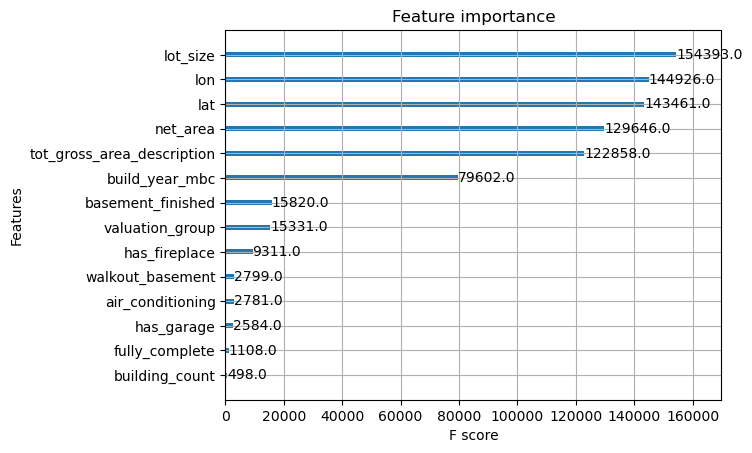

In [384]:
plot_importance(xgb)